Today we're going to walk through an example of predicting tumor and normal status directly from gene expression values. We'll be using the python package scikit learn to construct our SVM classifier. For machine learning, we highly recommend this package.

Lots of documentation is available:
http://scikit-learn.org/stable/documentation.html

We're going to be working on a support vector machine classifier. As we dig into the details, make sure you're referring to the documentation for more information:
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [46]:
import numpy as np
from sklearn import svm
from sklearn import preprocessing

In [47]:
# Define a useful helper function to read in our PCL files and store the gene names, 
# matrix of values, and sample names
# We'll use this function later, but we don't need to dig into how it works here.

def read_dataset(filename):
    data_fh = open(filename)
    samples = data_fh.readline().strip().split('\t')  # sample ids tab delimited
    gids = []  # gene ids will be stored here
    genes_samples = []  # genes x samples -- gene major
    for line in data_fh:
        toks = line.strip().split('\t')
        gids.append(toks[0])  # add gene id
        vals = [float(x) for x in toks[1:]]
        zarray = preprocessing.scale(vals) # make each gene's expression values comparable
        genes_samples.append(zarray)
    data_fh.close()
    #because we want samples x genes instead of genes x samples, we need to transpose
    samples_genes = np.transpose(np.array(genes_samples))
    return {'genes': gids, 'matrix': samples_genes, 'samples': samples}


In [48]:
# Use the function that we defined to read in our dataset
bric = read_dataset('METABRIC_dataset.pcl')

In [49]:
# Now we need to figure out which samples in metabric are tumors and which are normal.
# We will store this in status_list (matching each example in the dataset), so that we
# can provide this to scikit learn's SVM implementation.

status = {}  # hold tumor/normal status encoded as 1 (tumor)/2 (normal)
label_fh = open('tumor_normal_label.txt')
for line in label_fh:
    toks = line.strip().split()
    if toks[1] == 'Tumor':
        status[toks[0]] = 1
    elif toks[1] == 'Normal':
        status[toks[0]] = 2

status_list = []
for sample in bric['samples']:
    status_list.append(status[sample])


In [50]:
# Now we're going to construct a classifier. First we need to set up our parameters
svm_classifier = svm.SVC(C=0.000001, kernel='linear')

# Once our parameters are set, we can fit the classifier to our data
svm_classifier.fit(bric['matrix'], status_list)

# Once we have our classifier, we can apply it back to the examples and get our score
# Since this is binary classification. We get an accuracy.
score = svm_classifier.score(bric['matrix'], status_list)
print("Training Accuracy: " + str(score))


Training Accuracy: 0.932584269663


Congratulations! You've built your first SVM, and on training data it separates tumor data from normal data with over 90% accuracy! Now that we've done this with some biomedical data, let's take a step back and talk about things we should consider as we build a model.

_Q1: What are our labels?_

_Q2: What are our features?_

_Q3: What are our examples?_

### Overfitting in machine learning ###

When you train a computer to build a model that describes data that you've seen, a challenge known as "overfitting" can arise. When fitting the model, we want to find a model that fits the data as well as possible. However, real data is noisy. The model that fits data we have with the least error may capture the main features of the data, but may also capture noise in the data that we don't intend to model.  When a model fits noise in training data, we call this problem overfitting. 

For example, imagine that a professor wants to test a group of students' knowledge of calculus. She gives the students previous exam questions and answers to study. However, in the final exam, she uses the same questions to test the students. Some of the students could do very well because they memorized answers to the questions even though they don't understand calculus. The professor realizes this problem and then gives the students a new set of questions to test them. The students who memorized all the answers to previous exam questions may fail the new exam because they have no idea how to solve the new problems. We would say that those students have "overfit" to training data. 

How can overfitting be a problem with machine learning? Don't we want the model to fit the data as well as possible? The reason is we want a model that captures the features that will also exist in some new data. If the model fits the noise in the data, the model will perform poorly on new data sets! 

Let's use simulations to illustrate the overfitting problem. We are going to simulate two variables x and y and we let y = x + e, where e is some noise. That is, y is a linear function of x. 

In [51]:
## Load necessary Python packages
import numpy as np # numpy makes it convenient to load/modify matrices of data
import sklearn.linear_model as lm # this scikit learn module has code to fit a line
import matplotlib.pyplot as plt # this lets us plot our results
from sklearn.metrics import mean_squared_error # we use this to see how well our model fits data
%matplotlib inline

In [52]:
# This code will make our data by adding random noise to a linear relationship
# Simulate two variables x and y
# y=x+e, e is some noise
x = np.linspace(0., 2, 10)
y = x + 0.5*np.random.randn(len(x)) 

Let's plot the data. The code in the box below will do this. As we can see, the relation between x and y is linear but with some random noise.

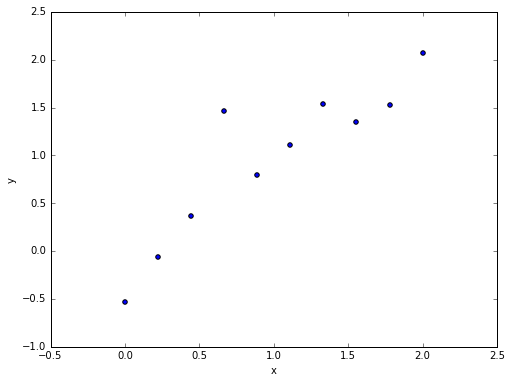

In [53]:
# This uses matplotlib to show points. You've seen a little bit of this before in the kmeans code
# We're using it for examples but you don't have to understand how this works.
# If you one day want to plot your results using python, you might want to keep this code
# as a reference.
plt.figure(figsize=(8,6))
plt.scatter(x[:100], y[:100])
plt.xlabel("x")
plt.ylabel("y")
#plt.plot(x, y)

Next, we want to train linear regression models on x and use the models to predict y. The models we are going to use are:  
1. A simple linear regression model: Y~X  
2. A complex multiple regression model: Y ~ X + X^2 + X^3 + X^4 ... + X^10  

We want to choose the model that will most accurately predict y.

Let's use ski-learn to train these two models:

In [54]:
# You don't need to know how this code works. We're not going to focus on regression
# during this course. You may want to have it to refer to in the future.

### simple regression
lr = lm.LinearRegression()
lr.fit(x[:,np.newaxis], y);
y_lr = lr.predict(x[:, np.newaxis])
### multiple regression
lrp = lm.LinearRegression()
lrp.fit(np.vander(x, N=10, increasing=True), y)
y_lrp = lrp.predict(np.vander(x, N=10, increasing=True))
x_plot = np.linspace(0., 2, 1000)
y_plot = lrp.predict(np.vander(x_plot, N=10, increasing=True))

Let's plot the fitting results.

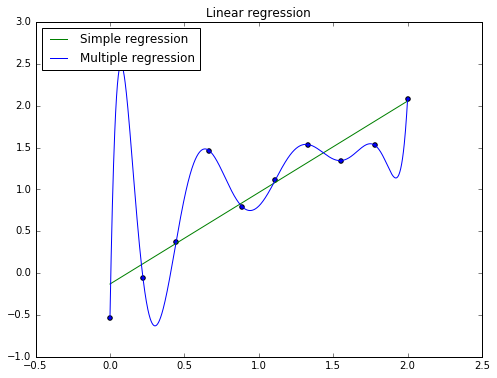

In [55]:
plt.figure(figsize=(8,6))
plt.scatter(x, y)
plt.plot(x, y_lr, 'g',label='Simple regression')
plt.title("Linear regression")
plt.plot(x_plot, y_plot,label='Multiple regression')
plt.legend(loc=2)

Let's calculate the MSE for simple regression model:

In [56]:
mean_squared_error(y, y_lr)

0.11226526085802499

Let's calculate the MSE for multiple regression model:

In [57]:
mean_squared_error(y, y_lrp)

1.9071226619872162e-21

The multiple regression model fits the data perferlly (MSE is almost 0). The predicted values are the exact the same as the observed values since the prediction curve goes through every point. However, the simple regression model captures the linear relation between x and y but it didn't predict perfectlly well with the observed values. Then, shoud we choose multiple regression model rather than simple regression model since the former fitts the data much better than the latter?

_Q4: Which model do you think is the better model? Why?_

Remember that we want to find a model that fits the data well and, most importantly, can predict well on some new data. Let's simulate some new data and see the prediction performance of each model on the new data. 

In [58]:
x_new = np.linspace(0., 2, 10)
y_new = x + 0.5*np.random.randn(len(x_new)) 
y_lr_new = lr.predict(x_new[:, np.newaxis])
y_lrp_new = lrp.predict(np.vander(x_new, N=10, increasing=True))

MSE for simple regression on new data:

In [59]:
mean_squared_error(y_new, y_lr_new)

0.33387506414693657

MSE for multiple regression on new data:

In [60]:
mean_squared_error(y_new, y_lrp_new)

0.44324326403952463

The multiple regression model (MSE=0.349) performs worse than simple regression model (MSE=0.232) on the new data. This is because the multiple regression model overfits the training data. It captures not only the true linear relation between x and y but also the random noise. However, simple regression only captures linear relation. 

This also demonstrates that it is not a good idea to train and evaluate a model on the same data set. If so, we tend to choose the model that overfits the data. However, in real data analysis, you will occasionally see papers reporting nearly perfect model fitting results. If you look closely, you will find that the authors fit and evaluate the model on the same data set. You now know that this is a typical overfitting problem. In your future research, be careful with the overfitting problem when you try some machine learning models on your data!

To avoid overfitting, there are several methods. One is to use regularization in the model to reduce the model complexity. The other is to train the model on one dataset and evaluate the model on a separate dataset. 

## Homework: BRCA Tumor/Normal - Revisited!

We are lucky enough to have an independent validation dataset of breast cancers from The Cancer Genome Atlas (TCGA). Let's see how our classifier does here!

In [61]:
# Let's read in the dataset and mark examples as tumor or normal depending on 
# how they are annotated the sample description file (BRCA.547.PAM50.SigClust.Subtypes.txt)

tcga = read_dataset('TCGA_dataset.pcl')
tcga_status = {}  # hol tumor/normal status encoded as 1 (tumor)/2 (normal)
label_fh = open('BRCA.547.PAM50.SigClust.Subtypes.txt')
for line in label_fh:
    toks = line.strip().split()
    if toks[1] == 'tumor-adjacent normal':
        tcga_status[toks[0]] = 2
    else:
        tcga_status[toks[0]] = 1

tcga_status_list = []
for sample in tcga['samples']:
    tcga_status_list.append(tcga_status[sample])


In [62]:
# Ok - now let's apply our classifier from before to these data:
tcga_score = svm_classifier.score(tcga['matrix'], tcga_status_list)
print("Testing Accuracy: " + str(tcga_score))


Testing Accuracy: 1.0


_Q0: Report the training and testing accuracy observed with C = 0.000001 (1 pt)_

_Q1: Do you think that your breast cancer classifier is under or overfitting your data? Why or why not? (3 pts)_

_Q2: Based on your answer to Q1, should you raise, lower, or keep C the same here? (1 pt)_

_Q3: Justify your answer to Q2 (3 pts)

_Q4: Try a different C. Report your training and testing accuracy (2 pts)._